In [39]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [40]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, auc, roc_curve, f1_score
import dask_ml.model_selection as dcv

from sklearn.model_selection import train_test_split
import lightgbm as lgb

import random
import imblearn as imblearn
from sklearn.preprocessing import MinMaxScaler

import Modeling_Helper
import Processing

import optuna
from optuna.samplers import TPESampler


import shap
shap.initjs()


import warnings
warnings.simplefilter('always', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('mode.chained_assignment', None)
import statsmodels.api as sm


# Predictive Modeling



## Logistic Regression

<div style="text-align: justify"> In the previous step, we ran EDA to understand the datasets and combine them while specifying which offer was successful. Here, we hypothesize that customer characteristics and offer attributes are associated with the likelihood of an offer becoming successful. To examine this hypothesis, we will build predictive models to find these potential associations. It is worth noting that while this model can provide insights about the purchasing likelihood, it cannot be directly used as a recommendation model. <br> <br>
To begin, we build a logistic model and use it as our baseline. The DataPrep class in the Modeling_Helper package can help us to to read the data, specify features, and create dummy variables upon categorical features.
The continuous variables are: <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - age <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - income <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - membership_days <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - duration <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - difficulty <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - num_channels <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - channel_mobile <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - channel_social <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - channel_web, <br>

and categorical variables are: <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - offer_id <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - offer_type <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - offer_reward <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - gender <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - membership_month <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - membership_year, <br>
</div>

In [19]:
data_prep = Modeling_Helper.DataPrep()
data_prep.prep_data_logistic()
modeling_data = data_prep.modeling_data
features = data_prep.features
y_var = data_prep.y_var
modeling_data.head()

,person,offer_id,time_received,offer_type,duration,offer_reward,difficulty,num_channels,channel_email,channel_mobile,...,membership_month_8.0,membership_month_9.0,membership_month_10.0,membership_month_11.0,membership_month_12.0,membership_year_2014.0,membership_year_2015.0,membership_year_2016.0,membership_year_2017.0,membership_year_2018.0
0,user_100,bogo_7_10,336.0,bogo,7.0,10,10,3,1,1,...,0,0,0,0,0,0,0,1,0,0
1,user_100,discount_10_5,0.0,discount,10.0,5,20,2,1,0,...,0,0,0,0,0,0,0,1,0,0
2,user_100,discount_10_5,576.0,discount,10.0,5,20,2,1,0,...,0,0,0,0,0,0,0,1,0,0
3,user_100,informational_4,408.0,informational,4.0,0,0,3,1,1,...,0,0,0,0,0,0,0,1,0,0
4,user_10002,informational_4,336.0,informational,4.0,0,0,3,1,1,...,0,0,0,1,0,0,1,0,0,0


<div style="text-align: justify"> We split the data into train and test using the DataSplit class in the Modeling_Helper package. We make sure that one person ID does not appear in both train and test set. Before building any model, we scale our variables and look at the correlation heatmap to see whether there are any highly correlation variables that we can remove. Looking at the heatmap below, we decide to keep all the variables that we have. However, the channel_email variables is dropped as it is equal to 1 for all offer IDs. 
</div>

In [20]:
data_split = Modeling_Helper.DataSplit('person', modeling_data, y_var, 0.8, 2021)
train_df, test_df = data_split.split_data()

In [21]:
scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(train_df.loc[:, features])
train_df.loc[: , features] = scaler.transform(train_df.loc[: , features])
test_df.loc[: , features] = scaler.transform(test_df.loc[: , features])

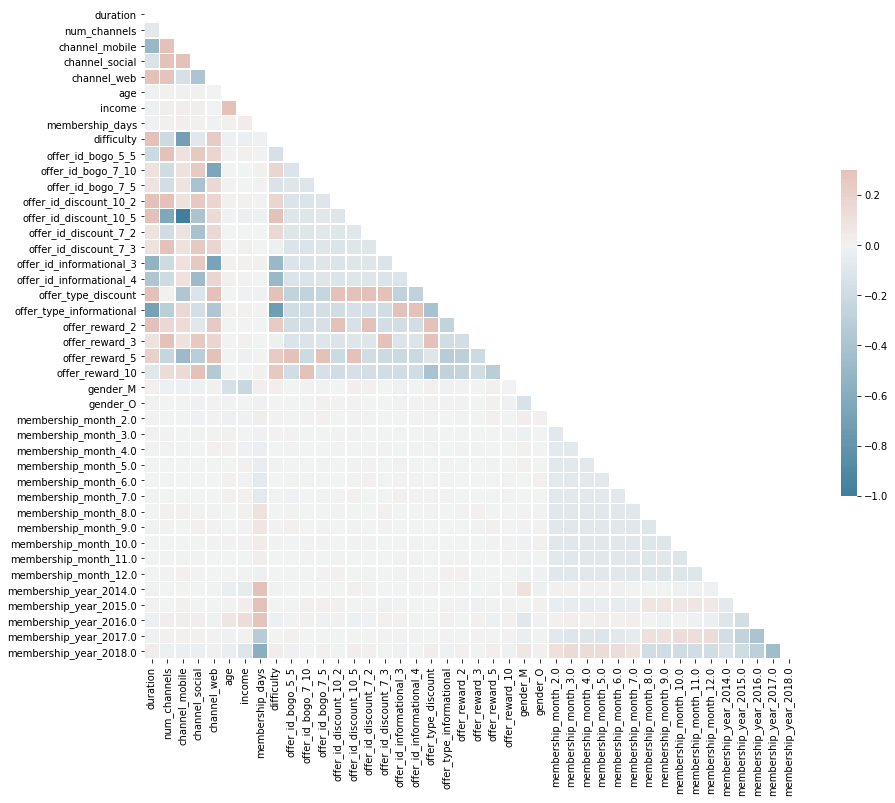

In [22]:
cor_df = Processing.correlation_map(train_df, data_prep.features)

<div style="text-align: justify"> Another characteristic of of our data is that it is highly imbalanced. The abundance of examples from the unsuccessful offers can swamp the successful ones.This means that if we train a model on such data, the algorithm will focus on learning the characteristics of the majority class only, neglecting the examples from the minority one whose predictions are more valuable. There are various ways to tackle this issue, with the most simple one being over-sampling the minority class which we use for our first model.
</div>

In [23]:
sm = imblearn.over_sampling.RandomOverSampler(random_state=2021)
X_train_res, y_train_res = sm.fit_resample(train_df[features], train_df[y_var].ravel())
X_train_res[y_var] = y_train_res

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

After OverSampling, the shape of train_X: (93062, 43)
After OverSampling, the shape of train_y: (93062,) 

After OverSampling, counts of label '1': 46531
After OverSampling, counts of label '0': 46531


In [24]:
import statsmodels.api as sm
X_train_res = sm.add_constant(X_train_res, has_constant='add')
logit_model=sm.Logit(X_train_res[y_var], X_train_res[['const']+features])
logit_model=logit_model.fit()
print(logit_model.summary2())

         Current function value: 0.607410
         Iterations: 35
                                                 Results: Logit
Model:                              Logit                           Pseudo R-squared:                0.124      
Dependent Variable:                 successful_offer                AIC:                             113121.6194
Date:                               2021-12-09 11:10                BIC:                             113442.6142
No. Observations:                   93062                           Log-Likelihood:                  -56527.    
Df Model:                           33                              LL-Null:                         -64506.    
Df Residuals:                       93028                           LLR p-value:                     0.0000     
Converged:                          0.0000                          Scale:                           1.0000     
No. Iterations:                     35.0000                                    

Maximum Likelihood optimization failed to converge. Check mle_retvals


<div style="text-align: justify"> Building our logistic model, we can use the PerformanceAnalysis function (in Modeling_Helper) to analyze the performance. As shown below, the model results in an accuracy of 0.67, precision of 0.65, recall of 0.71, and F1 score of 0.68 on the train set and on the test set these numbers are 0.63, 0.05, 0.67, and 0.1. The train set's AUC is 0.73 and for test set, it is 0.69. It is apparent that there is a significant level of over-fitting, meaning that our model learned too much from the train set so that it is not able to generalize over the unseen data (test set).
</div>

************** Performance: Train Set **************** 

Accuracy: 0.67
Precision: 0.65
Recall: 0.71
F1: 0.68


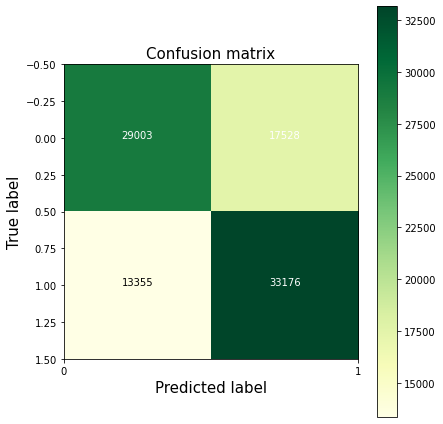

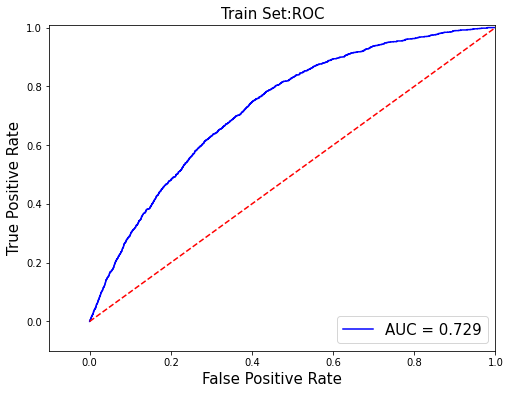

************** Performance: Test Set **************** 

Accuracy: 0.63
Precision: 0.05
Recall: 0.67
F1: 0.1


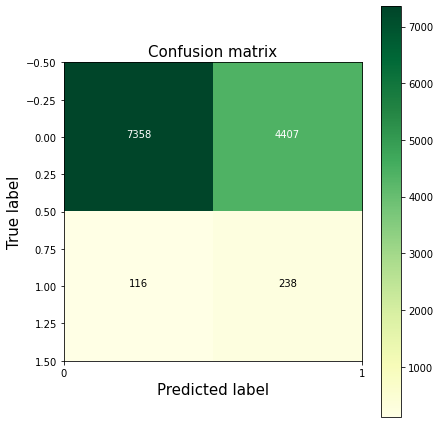

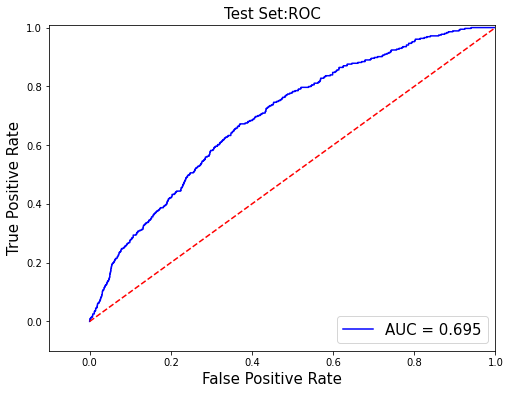

In [25]:
perf_analysis = Modeling_Helper.PerformanceAnalysis(logit_model, X_train_res, ['const']+features, y_var, 'Train Set', prob = False)
perf_analysis.perf_analysis()

test_df = sm.add_constant(test_df, has_constant='add')
perf_analysis = Modeling_Helper.PerformanceAnalysis(logit_model, test_df, ['const']+features, y_var, 'Test Set', prob = False)
perf_analysis.perf_analysis()

## Gradient Boosting Machines (GBM)

<div style="text-align: justify"> Having the logistic model as the baseline, now the question is whether we can train a better model. Gradient Boosting Machines or GBM models are a family of powerful machine learning algorithms that have been successfully leveraged and implemented in various domains. They are highly customizable to the particular needs of the application, like being learned with respect to different loss functions. Boosting is generally a technique for transforming weak learners into strong learners. Gradient boosting mainly consists of three components: (1) a loss function to be optimized which depends on the type of problem being solved, (2) a weak learner to make predictions which is a decision tree in this case, and (3) an additive model to add weak learners to minimize the loss function (i.e. follow the gradient) [<a href="https://www.frontiersin.org/articles/10.3389/fnbot.2013.00021/full">1</a>]. To build such a model, we use the LightGBM package which is a gradient boosting framework that uses tree-based learning algorithms [<a href="https://lightgbm.readthedocs.io/en/latest/">2</a>].
    
We can use the DataPrep class in Modeling_Helper to prepare the data and this time we use the prep_data_gbm function. One nice capability of the LightGBM is that it can handle categorical variables internally and we do not need to transform them into binary variables. The prep_data_gbm function takes care of this and changes the type of categorical columns to category. Similar to before, we use the DataSplit class to split the data into train and test. We would not tweak the parameters for the first iteration of the model; however, there are two which are essential. First, we need to specify the objective. objective specifies the learning task and the corresponding learning objective. this parameter is defaulted to regression but since our response variable is whether an offer was successful or not, we need to change it to binary. In building the logistic regression model, we mentioned that our data is imbalanced and we iterated the challenges it may impose the model with. We used over-sampling to remedy this issue. With out GBM model, we are going to follow a similar path but differently. Instead of over-sampling our data, we leverage the scale_pos_weight parameter which is the ratio of number of negative class to the positive class and can be used to scale the gradient for the positive class. this parameter ensures that errors made by the model during training on the positive class are scaled and it persuades to correct for them more often. As a result, the model will make better predictions on the positive class. Looking at the train set, this value is equal to 33.4. Building our first GBM model, We can achieve an accuracy of 0.77, precision of 0.11, recall of 0.95, and F1 score of 0.19 on the train set and on the test set these numbers are 0.76, 0.06, 0.5, and 0.1. The train set's AUC is 0.92 and for test set, it is 0.69.
 
</div>

In [41]:
data_prep = Modeling_Helper.DataPrep()
data_prep.prep_data_gbm()
modeling_data = data_prep.modeling_data
features = data_prep.features
cat_vars = data_prep.cat_vars
y_var = data_prep.y_var
modeling_data.head()

,person,offer_id,time_received,offer_type,duration,offer_reward,difficulty,num_channels,channel_email,channel_mobile,channel_social,channel_web,gender,age,income,membership_days,membership_month,membership_year,successful_offer
0,user_100,bogo_7_10,336.0,bogo,7.0,10,10,3,1,1,1,0,F,68.0,84000.0,1941.0,7.0,2016.0,0
1,user_100,discount_10_5,0.0,discount,10.0,5,20,2,1,0,0,1,F,68.0,84000.0,1941.0,7.0,2016.0,0
2,user_100,discount_10_5,576.0,discount,10.0,5,20,2,1,0,0,1,F,68.0,84000.0,1941.0,7.0,2016.0,0
3,user_100,informational_4,408.0,informational,4.0,0,0,3,1,1,0,1,F,68.0,84000.0,1941.0,7.0,2016.0,0
4,user_10002,informational_4,336.0,informational,4.0,0,0,3,1,1,0,1,M,69.0,62000.0,2193.0,11.0,2015.0,0


In [42]:
data_split = Modeling_Helper.DataSplit('person', modeling_data, y_var, 0.8, 2021)
train_df, test_df = data_split.split_data()
scale_pos_weight_val = (len(train_df)-sum(train_df[y_var]))/sum(train_df[y_var])
print(scale_pos_weight_val)

33.42744252873563


In [43]:
train_data = lgb.Dataset(train_df[features], label=train_df[y_var],free_raw_data=False)
test_data = lgb.Dataset(test_df[features], label=test_df[y_var], free_raw_data=False)

In [44]:
params = {'num_threads':-1, 
          'seed':2021, 
          'verbose': -1,
          'objective': "binary",  
          'scale_pos_weight':scale_pos_weight_val
         }

gbm_model = lgb.train(params,
            train_data,
            feature_name=features,
            categorical_feature=cat_vars,
            verbose_eval=-1,
                     )

categorical_feature in Dataset is overridden.
New categorical_feature is ['gender', 'membership_month', 'membership_year', 'offer_id', 'offer_reward', 'offer_type']


************** Performance: Train Set **************** 

Accuracy: 0.77
Precision: 0.11
Recall: 0.95
F1: 0.19


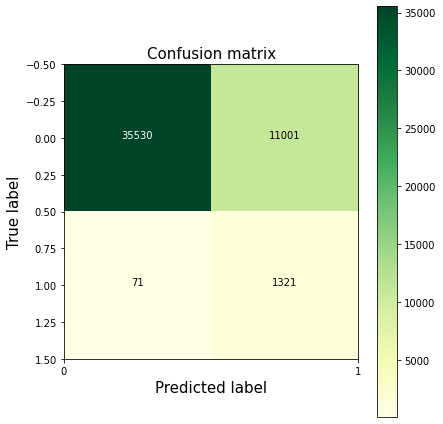

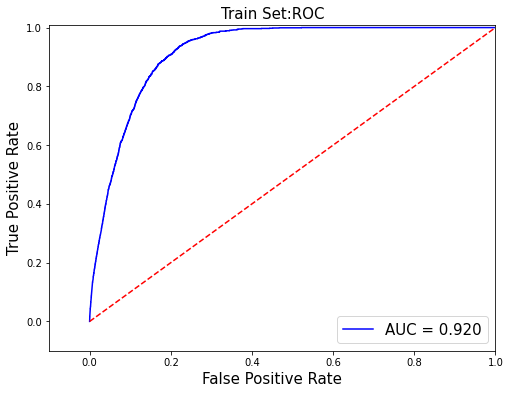

************** Performance: Test Set **************** 

Accuracy: 0.76
Precision: 0.06
Recall: 0.5
F1: 0.11


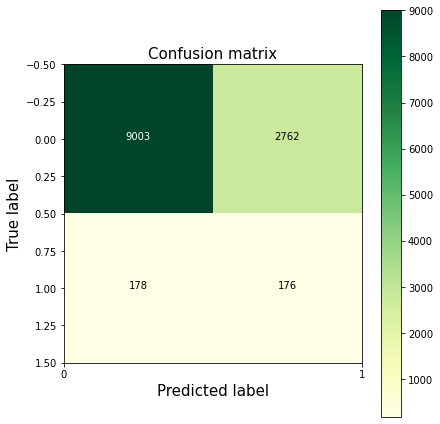

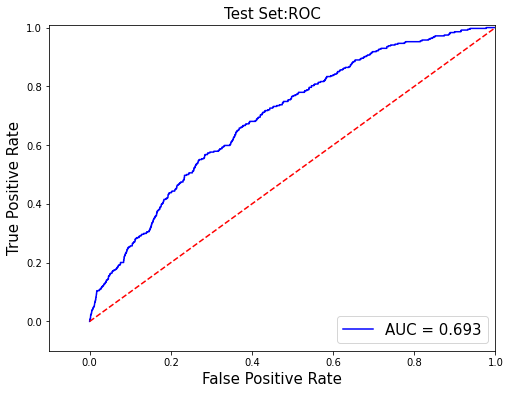

In [45]:
perf_analysis = Modeling_Helper.PerformanceAnalysis(gbm_model, train_df, features, y_var, 'Train Set', prob = False)
perf_analysis.perf_analysis()
perf_analysis = Modeling_Helper.PerformanceAnalysis(gbm_model, test_df, features, y_var, 'Test Set', prob = False)
perf_analysis.perf_analysis()

<div style="text-align: justify"> GBM models by themselves are not interpretable, at least not easily and GBMs are not alone in that. Many complex models that can achieve the highest accuracy for large modern datasets can be quite challenging to interpret. Lundberg and Lee however responded to that challenge and proposed the SHAP (SHapley Additive exPlanations) values that can show how much each independent variable contributes to the response variable [<a href="https://proceedings.neurips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf">3</a>]. Leveraging SHAP values not only we can find the importance of each variable but also the positive/negative relationships that each variable has in regard to the response variable. These values can be found using the Python module shap. We use this package, to see how each variable in our dataset contributes into an offer becoming successful. Below, you can see our SHAP plot using the train set. Now, let's try and understand this plot. The dots your are seeing in this plot are pertinent to each observation in the train set. Variables are ranked based on the their importance. While for continuous variables we have a gradient of colors from blue to red indicating the feature value, categorical variables are naturally gray. The horizontal location specifies whether the effect of that value results in higher or lower predictions. Let's use income as an example. It seems that overall higher income is associated with higher likelihood of an offer becoming successful.
</div>

In [35]:
explainer = shap.TreeExplainer(gbm_model)
shap_values = explainer.shap_values(train_df[features])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


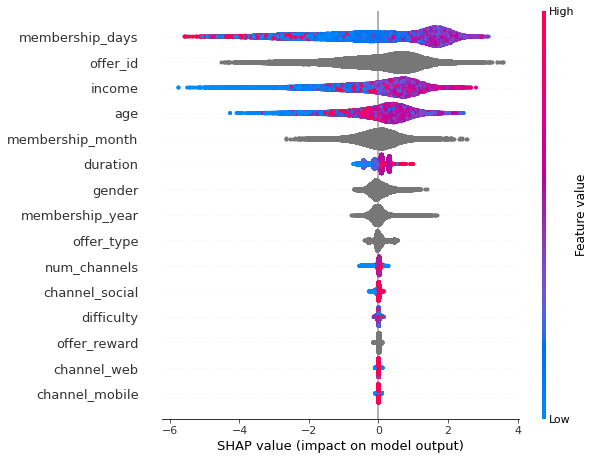

In [36]:
shap.summary_plot(shap_values[1], train_df[features], feature_names = features, max_display = 30)

<div style="text-align: justify"> Now, we try to improve our initial GBM model following three approaches:<br>
&nbsp;&nbsp;&nbsp;&nbsp;            - More feature engineering <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - Hard encoding interactions <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - Hyperparameter tuning <br>
    
</div>

### GBM: Feature Engineering

<div style="text-align: justify"> One additional feature that we can add to the data is the cumulative number of offers that each user has received at each time. Our hypothesis is that the more that we target the users (sending more offers), users' likelihood of successfully completing an offer will increase. Another feature that we can tweak is the membership month. So far, we treated this variable as categorical, but is it really? The hour of day and the month of year are indeed cyclical features and they need to be transformed into a representation that can properly preserve information such as the 12th month and the first month are close to each other. A common method to encode cyclical features is to transform them into two dimensions using sine and cosine functions, as done below (Learn More [<a href="https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca">4</a>]). Now we can include these two newly created continuous features in our model and maintain the cyclical nature of the month data. <br>
Tree-based method intrinsically take into account the interactions between independent variables. Having said that, we can hard-encode some of the interactions to make it easier for the model to pick them up. Looking at SHAP values, we found that membership days and income are among the most important variable in the model. We hypothesize that that there is an interactive effect among these two. We also include the interaction terms between income and the number of channels and between age and income.
</div>

In [49]:
modeling_data = modeling_data.sort_values(by = ['person', 'time_received']).reset_index(drop = True)
modeling_data['num_offers'] = modeling_data.groupby('person')['time_received'].transform(lambda group: group.astype('category').cat.codes + 1)
modeling_data['membership_month_sin'] = np.sin(2 * np.pi * modeling_data['membership_month'].astype(int) / 12)
modeling_data['membership_month_cos'] = np.cos(2 * np.pi * modeling_data['membership_month'].astype(int) / 12)
modeling_data['membership_days_X_income'] = modeling_data['membership_days']*modeling_data['income']
modeling_data['num_channels_X_income'] = modeling_data['num_channels']*modeling_data['income']
modeling_data['age_X_income'] = modeling_data['age']*modeling_data['income']

In [50]:
cont_vars = [
    'duration',
    'num_channels',
    'channel_email', 
    'channel_mobile', 
    'channel_social', 
    'channel_web',
    'age',  
    'income',
    'membership_days',
    'num_offers',
    'membership_days_X_income',
    'num_channels_X_income',
    'age_X_income',
    'membership_month_sin',
    'membership_month_cos',
    'difficulty',

]

cat_vars = [
    'offer_id',
    'offer_type',
    'offer_reward',
    'gender', 
    'membership_year'
]

features = cont_vars+cat_vars

y_var = 'successful_offer'

for i in cat_vars:
    modeling_data.loc[:, i] = modeling_data[i].astype('category')

In [51]:
data_split = Modeling_Helper.DataSplit('person', modeling_data, y_var, 0.8, 2021)
train_df, test_df = data_split.split_data()
scale_pos_weight_val = (len(train_df)-sum(train_df[y_var]))/sum(train_df[y_var])

### GBM: Hyper-parameter Tuning

<div style="text-align: justify"> As we mentioned before, GBMs are highly customizable and there are many hyper-parameters that we can tune to achieve a better performance. Among many hyper-parameters, we will focus on the following ones:<br>
&nbsp;&nbsp;&nbsp;&nbsp;            - learning_rate: this can slow down or speed up the learning. Smaller values can decrease the influence of each individual tree and leaves space for future trees to improve the model. <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - n_estimators: this determines the number of boosting iterations. The more trees the more accurate our model can be but at the same time, it will increase the training time and there will be a higher chance of over-fitting. <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - max_depth: this controls the maximum depth of each trained tree. Smaller values can improve the training speed and address potential overfitting. <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - num_leaves: this will control the complexity of the model. It specifies the maximum number of leaves each weak learner has. Large values will improve the accuracy of the model but also can the chance of over-fitting. <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - colsample_bytree: this specifies the fraction of features to consider at each iteration. It can be used to speed up training and to deal with over-fitting. <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - reg_alpha: this applies L1 regularization and can address over-fitting. <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - reg_lambda: this applies L2 regularization and can address over-fitting.<br>
&nbsp;&nbsp;&nbsp;&nbsp;            - min_child_samples: this determines the minimal number of data in one leaf and can be used to deal with over-fitting. <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - subsample: this specifies the percentage of observations (which are selected randomly) used in each iteration. Smaller values can improve the training speed since. It can also improve generalization over unseen data.  <br>

Now that we specified our hyper-parameters of interest, the question is how to tune them. The important note here is that we should not use our test set to do so as it will cause data leakage. We can either create a separate validation set or we can leverage cross-validation. Since we don't have a very large dataset to split it into three sets, we rely on cross-validation. There are various methods to find the best hyper-parameters including grid search and random search. However, here we utilize a specific method called Bayesian Optimization. Bayesian Optimization is a probabilistic approach to find the minimum of any function that returns a particular metric, particularly effective in hyper-parameter tuning for complex machine learning models. It utilizes the Bayes theorem by setting a prior over the objective function and find the posterior function by combining it with evidence coming from the data. Unlike grid and random search methods, this approach keeps track of previous results and uses them to create a model associating hyper-parameters to a probability. This technique will move our prior understanding of the hyper-parameters and re-shape them according to the structure of the dataset in hand (Learn More [<a href="https://static.sigopt.com/b/20a144d208ef255d3b981ce419667ec25d8412e2/static/pdf/SigOpt_Bayesian_Optimization_Primer.pdf">5</a>]). To implement this method, we use the Optuna module and create our own class called BayesianOpt (van be found in the Modeling_Helper). Below, we summarize the steps that we took to create this class: <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - In the init function, specify the train set, features, response variable and the value for scale_pos_weight. <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - In the call function, specify the hyper parameters to tune, and the range to search within. <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - Build the GBM model with the found hyper-parameters. <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - Use cross-validation to find the score associated with the hyper-parameters. <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - Return the best score. <br>

We specify our score of interest to be the F1 score, meaning that the Bayesian optimization will try to find the best set of hyper-parameters to maximize the F1 score coming from the cross-validation on train set. We run our optimization for 100 iteration and will check the progress.

</div>

In [14]:
sampler = TPESampler(seed=2021)  
study = optuna.create_study(sampler = sampler, direction="maximize")
study.optimize(Modeling_Helper.BayesianOpt(train_df, features, y_var, scale_pos_weight_val), n_trials=100)

[I 2021-11-29 15:36:19,428] A new study created in memory with name: no-name-6643f4d6-bf3e-4aca-8416-569395d2ccc4
[I 2021-11-29 15:36:48,448] Trial 0 finished with value: 0.11309781035250034 and parameters: {'learning_rate': 0.0377391257196892, 'num_leaves': 45, 'colsample_bytree': 0.311157725382719, 'reg_alpha': 0.06980640530295552, 'reg_lambda': 4.915069954353206, 'max_depth': 5, 'min_child_samples': 148, 'subsample': 0.8023403430208751, 'n_estimators': 1493}. Best is trial 0 with value: 0.11309781035250034.
[I 2021-11-29 15:37:10,858] Trial 1 finished with value: 0.11111240402162112 and parameters: {'learning_rate': 0.10985555325894224, 'num_leaves': 7, 'colsample_bytree': 0.2468570280704288, 'reg_alpha': 3.958019320953226, 'reg_lambda': 0.4613919861163953, 'max_depth': 4, 'min_child_samples': 359, 'subsample': 0.6932197668943921, 'n_estimators': 1946}. Best is trial 0 with value: 0.11309781035250034.
[I 2021-11-29 15:37:44,555] Trial 2 finished with value: 0.1100649018418246 and pa

[I 2021-11-29 15:54:01,527] Trial 20 finished with value: 0.11611691740759032 and parameters: {'learning_rate': 0.021091124469863266, 'num_leaves': 50, 'colsample_bytree': 0.7595859838046863, 'reg_alpha': 0.02006614161782962, 'reg_lambda': 1.1206465330018285, 'max_depth': 14, 'min_child_samples': 227, 'subsample': 0.9258033626967777, 'n_estimators': 1168}. Best is trial 19 with value: 0.14152844269148004.
[I 2021-11-29 15:54:58,186] Trial 21 finished with value: 0.13569554672406198 and parameters: {'learning_rate': 0.0010564635078824474, 'num_leaves': 48, 'colsample_bytree': 0.9121774132569622, 'reg_alpha': 0.012110206548878798, 'reg_lambda': 1.1127096405786758, 'max_depth': 20, 'min_child_samples': 294, 'subsample': 0.8036450224570105, 'n_estimators': 1268}. Best is trial 19 with value: 0.14152844269148004.
[I 2021-11-29 15:55:56,790] Trial 22 finished with value: 0.13486596232653353 and parameters: {'learning_rate': 0.0010606589827079817, 'num_leaves': 48, 'colsample_bytree': 0.99642

[I 2021-11-29 16:07:47,979] Trial 40 finished with value: 0.10513325444616219 and parameters: {'learning_rate': 0.04825763182452712, 'num_leaves': 42, 'colsample_bytree': 0.9728621076503364, 'reg_alpha': 0.24610507171091725, 'reg_lambda': 0.15238080753879868, 'max_depth': 23, 'min_child_samples': 193, 'subsample': 0.3503539183961863, 'n_estimators': 708}. Best is trial 31 with value: 0.1419151566852487.
[I 2021-11-29 16:08:20,285] Trial 41 finished with value: 0.0 and parameters: {'learning_rate': 0.0014068344784059865, 'num_leaves': 47, 'colsample_bytree': 0.9266630061813697, 'reg_alpha': 0.0312518342839361, 'reg_lambda': 2.7642570517508283, 'max_depth': 26, 'min_child_samples': 502, 'subsample': 0.7687209138693255, 'n_estimators': 613}. Best is trial 31 with value: 0.1419151566852487.
[I 2021-11-29 16:08:56,020] Trial 42 finished with value: 0.13670659761248133 and parameters: {'learning_rate': 0.0018867683173548287, 'num_leaves': 45, 'colsample_bytree': 0.8989481756702321, 'reg_alph

[I 2021-11-29 16:18:08,219] Trial 60 finished with value: 0.14444501653001848 and parameters: {'learning_rate': 0.0016315997857535868, 'num_leaves': 27, 'colsample_bytree': 0.5366655308143199, 'reg_alpha': 0.07088850673123137, 'reg_lambda': 1.329795453959223, 'max_depth': 23, 'min_child_samples': 469, 'subsample': 0.9786795073787806, 'n_estimators': 664}. Best is trial 60 with value: 0.14444501653001848.
[I 2021-11-29 16:18:27,544] Trial 61 finished with value: 0.14505585908392027 and parameters: {'learning_rate': 0.001651540420257919, 'num_leaves': 26, 'colsample_bytree': 0.5546771722017886, 'reg_alpha': 0.11511983596488812, 'reg_lambda': 1.402881028322646, 'max_depth': 25, 'min_child_samples': 470, 'subsample': 0.966533554147176, 'n_estimators': 660}. Best is trial 61 with value: 0.14505585908392027.
[I 2021-11-29 16:18:46,474] Trial 62 finished with value: 0.14395856519425043 and parameters: {'learning_rate': 0.0016749421777113734, 'num_leaves': 25, 'colsample_bytree': 0.54064737378

[I 2021-11-29 16:26:00,978] Trial 80 finished with value: 0.1205143992592462 and parameters: {'learning_rate': 0.002474878388945733, 'num_leaves': 26, 'colsample_bytree': 0.5426246792608881, 'reg_alpha': 0.313271617386336, 'reg_lambda': 1.4050008159764267, 'max_depth': 22, 'min_child_samples': 197, 'subsample': 0.9817511102745612, 'n_estimators': 803}. Best is trial 61 with value: 0.14505585908392027.
[I 2021-11-29 16:26:59,318] Trial 81 finished with value: 0.11167258232817735 and parameters: {'learning_rate': 0.001911661615944234, 'num_leaves': 32, 'colsample_bytree': 0.5930420941776336, 'reg_alpha': 0.07690129633352104, 'reg_lambda': 2.3611942157410937, 'max_depth': 26, 'min_child_samples': 463, 'subsample': 0.8801981492145364, 'n_estimators': 1787}. Best is trial 61 with value: 0.14505585908392027.
[I 2021-11-29 16:27:19,017] Trial 82 finished with value: 0.14207469250384364 and parameters: {'learning_rate': 0.0018732900800033955, 'num_leaves': 29, 'colsample_bytree': 0.45007201019

<div style="text-align: justify"> In the plot below, you can see the cumulative best F1 score in each iteration. We started from an F1 score of around 0.11 and we were able to improve it to 0.145 after 100 iterations. The best hyper-parameters found are as following:<br>
&nbsp;&nbsp;&nbsp;&nbsp;            - learning_rate: 0.00165 <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - n_estimators: 660 <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - max_depth: 25 <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - num_leaves: 26 <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - colsample_bytree: 0.555 <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - reg_alpha: 0.115 <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - reg_lambda: 1.403 <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - min_child_samples: 470 <br>
&nbsp;&nbsp;&nbsp;&nbsp;            - subsample: 0.967  <br>
 
</div>

Optuna best score = 0.1451


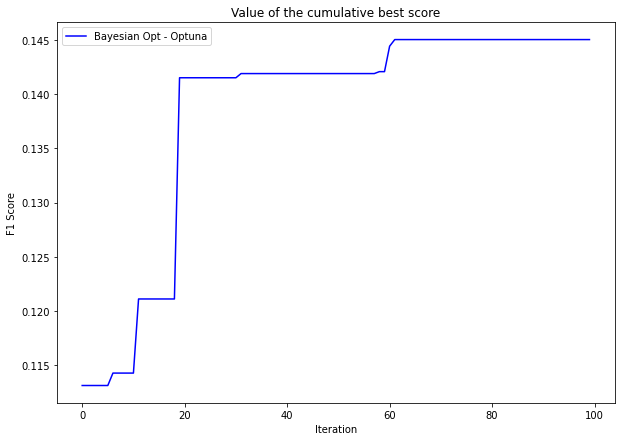

In [15]:
op_tuna_cummax = np.array(study.trials_dataframe()["value"].cummax()) 
print(f'Optuna best score = {op_tuna_cummax[-1]:.4f}')
fig = plt.figure(figsize = (10, 7))
plt.plot(op_tuna_cummax, 'b', label='Bayesian Opt - Optuna')
plt.xlabel('Iteration')
plt.ylabel('F1 Score')
plt.title('Value of the cumulative best score');
plt.legend()

### GBM: Final Model

<div style="text-align: justify"> Now, we take the best hyper-parameters found from the Bayesian Optimization and build our final model and assess the performance on both train and test sets. As shown below, this model achieved an accuracy of 0.92, precision of 0.11, recall of 0.24, and F1 score of 0.15 on the train set and on the test set these numbers are 0.92, 0.11, 0.24, and 0.15. The train set's AUC is 0.8 and for test set, it is 0.75.
 
</div>

In [16]:
best_params = study.best_params
best_params

{'learning_rate': 0.001651540420257919,
 'num_leaves': 26,
 'colsample_bytree': 0.5546771722017886,
 'reg_alpha': 0.11511983596488812,
 'reg_lambda': 1.402881028322646,
 'max_depth': 25,
 'min_child_samples': 470,
 'subsample': 0.966533554147176,
 'n_estimators': 660}

In [52]:
best_params = {'learning_rate': 0.001651540420257919,
 'num_leaves': 26,
 'colsample_bytree': 0.5546771722017886,
 'reg_alpha': 0.11511983596488812,
 'reg_lambda': 1.402881028322646,
 'max_depth': 25,
 'min_child_samples': 470,
 'subsample': 0.966533554147176,
 'n_estimators': 660}

In [53]:
train_data = lgb.Dataset(train_df[features], label=train_df[y_var],free_raw_data=False)
test_data = lgb.Dataset(test_df[features], label=test_df[y_var], free_raw_data=False)

In [54]:
params = {'objective': "binary", 'metric': ['binary_logloss', 'binary_error'], 'num_threads':-1, 'seed':2021, 'verbose': -1,
              
            'learning_rate':best_params['learning_rate'], 
            'num_leaves':best_params['num_leaves'], 
            'colsample_bytree': best_params['colsample_bytree'],
            'reg_alpha':best_params['reg_alpha'],
            'reg_lambda': best_params['reg_lambda'],
                      'max_depth': best_params['max_depth'],
            'min_child_samples': best_params['min_child_samples'],
            'subsample': best_params['subsample'],
            'n_estimators': best_params['n_estimators'],

            'scale_pos_weight':scale_pos_weight_val
         }

gbm_model = lgb.train(params,
            train_data,
            feature_name=features,
            categorical_feature=cat_vars,
            verbose_eval=-1,
                     )

Found `n_estimators` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['gender', 'membership_year', 'offer_id', 'offer_reward', 'offer_type']


************** Performance: Train Set **************** 

Accuracy: 0.92
Precision: 0.11
Recall: 0.24
F1: 0.15


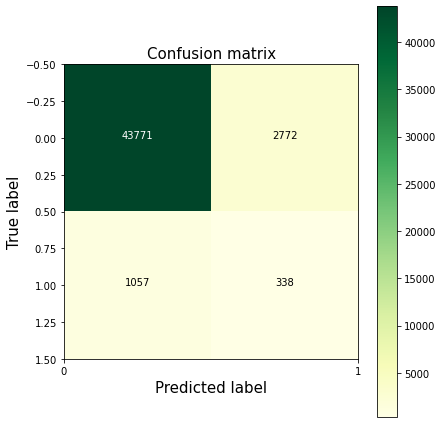

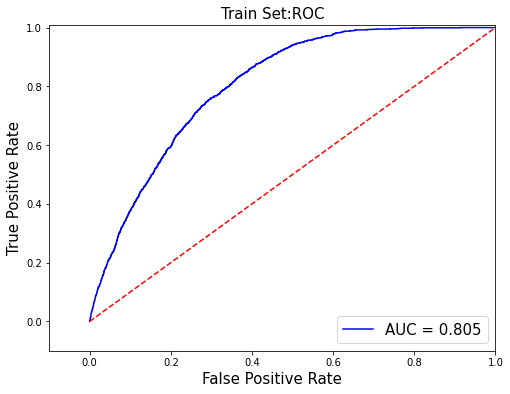

************** Performance: Test Set **************** 

Accuracy: 0.92
Precision: 0.11
Recall: 0.24
F1: 0.15


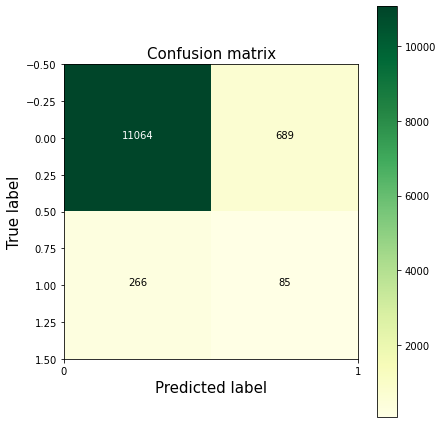

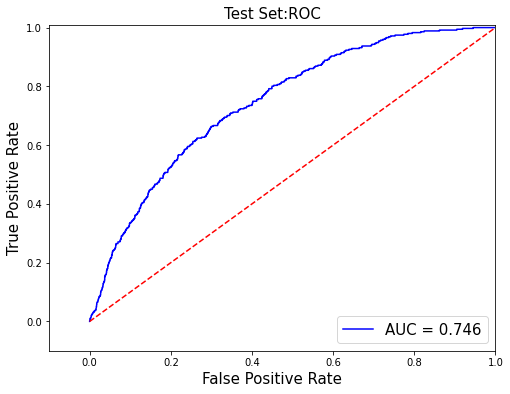

In [55]:
perf_analysis = Modeling_Helper.PerformanceAnalysis(gbm_model, train_df, features, y_var, 'Train Set', prob = False)
perf_analysis.perf_analysis()
perf_analysis = Modeling_Helper.PerformanceAnalysis(gbm_model, test_df, features, y_var, 'Test Set', prob = False)
perf_analysis.perf_analysis()

<div style="text-align: justify"> Let's see how much we were able to improve our baseline model (logistic regression). We were able to improve our metric of interest (F1 score) by 50%, along with the AUC, accuracy, precision, and recall. Another interesting achievement here is that we were able to address a lot of the over-fitting that we observed in our logistic model and now the performance metrics in our train and test set are close to each other. Taking another look at the SHAP values, we observe that some of the hard-encoded interaction terms that we defined are among the most important features. We save this model so can be used later on for scoring purposes.
</div>

In [73]:
performance_dict = {'logisitc':{'auc': 0.695,
'accuracy': 0.63,
'precision': 0.05,
'recall': 0.67,
'f1_score': 0.1}, 'gbm': {'auc': 0.746,
'accuracy': 0.92,
'precision': 0.11,
'recall': 0.24,
'f1_score': 0.15}}

In [74]:
Modeling_Helper.performance_comparison(performance_dict)

Improvement in AUC:  7.34 %
Improvement in Accuracy:  46.03 %
Improvement in Precision:  120.0 %
Improvement in Recall:  -64.18 %
Improvement in F1 Score:  50.0 %


In [75]:
explainer = shap.TreeExplainer(gbm_model)
shap_values = explainer.shap_values(train_df[features])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


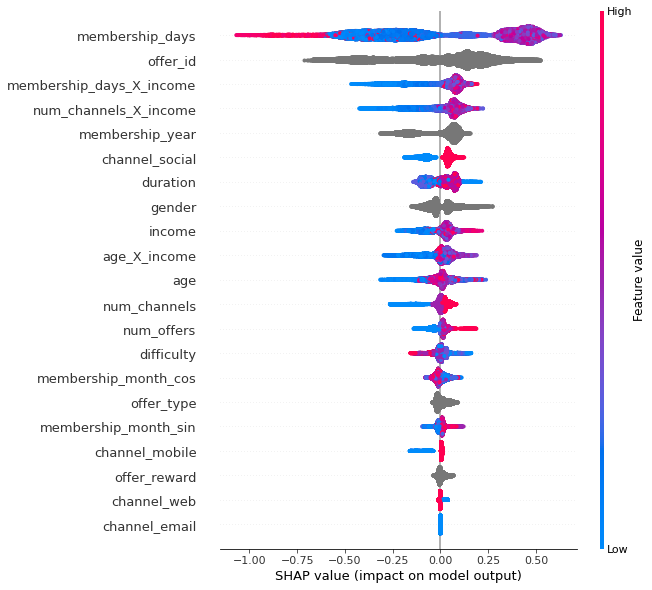

In [76]:
shap.summary_plot(shap_values[1], train_df[features], feature_names = features, max_display = 30)

In [77]:
import joblib
# save model
joblib.dump(gbm_model, 'gbm_model.pkl')

['gbm_model.pkl']